<a href="https://colab.research.google.com/github/ShrutikSingh/Anomaly_Detection_Model/blob/main/Sensor_Data_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
# Step 2: Upload  CSV File
from google.colab import files
uploaded = files.upload()


Saving data_3hrs.csv to data_3hrs.csv


In [8]:
# Step 3: Load and Preprocess Data
try:
    df = pd.read_csv('data_3hrs.csv', encoding='latin1')  # Try reading with latin1 encoding
except UnicodeDecodeError:
    try:
        df = pd.read_csv('data_3hrs.csv', encoding='cp1252') # Try reading with cp1252 encoding
    except UnicodeDecodeError:
        print("Could not decode the file with latin1 or cp1252 encoding. Please check the file encoding.")

        exit()

df = df.drop(columns=['Temperature (°F)'])

# Rename columns for consistency
df.rename(columns={
    'Timestamp (ms)': 'timestamp',
    'Humidity (%)': 'humidity',
    'Temperature (°C)': 'temperature'
}, inplace=True)

# Convert timestamp from milliseconds to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Show first few rows
df.head()


,timestamp,humidity,temperature
0,1970-01-01 00:00:00,43.70,24.80
1,1970-01-01 00:00:02,45.26,24.76
2,1970-01-01 00:00:04,44.97,24.83
3,1970-01-01 00:00:06,45.96,25.68
4,1970-01-01 00:00:08,46.24,25.84


In [9]:
# Convert timestamp if present
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Interpolate missing temperature and humidity values
df['temperature'] = df['temperature'].interpolate()
df['humidity'] = df['humidity'].interpolate()

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['temperature', 'humidity']])


In [18]:
# Step 3: Check for missing values, we see that there are no null vaules
df.isnull().sum()


,0
timestamp,0
humidity,0
temperature,0
anomaly_iso,0
anomaly_db,0


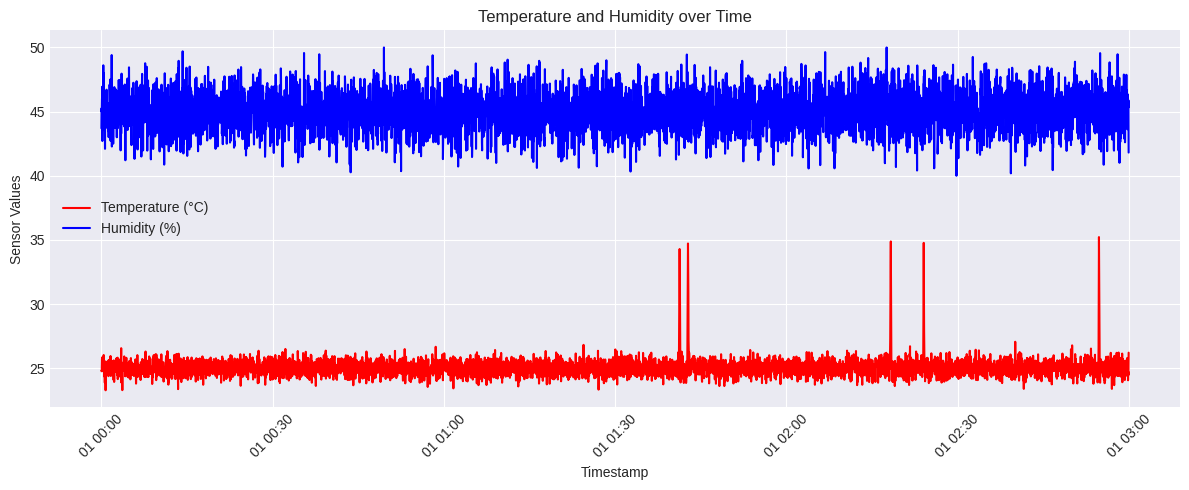

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot temperature and humidity over time
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['temperature'], label='Temperature (°C)', color='red')
plt.plot(df['timestamp'], df['humidity'], label='Humidity (%)', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Sensor Values')
plt.title('Temperature and Humidity over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


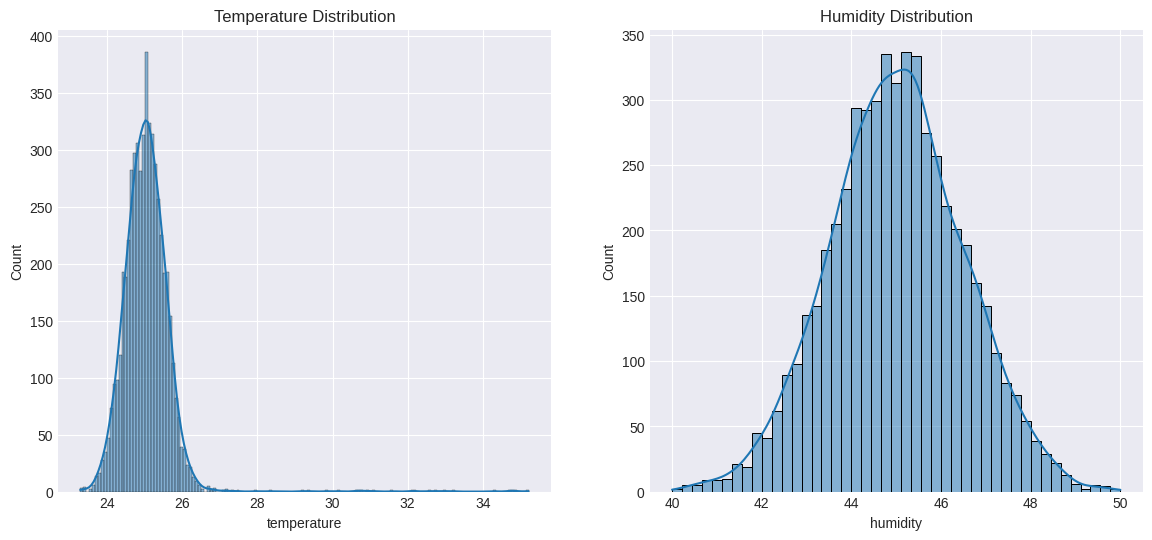

In [11]:
# Step 6: Distribution Plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['temperature'], kde=True)
plt.title('Temperature Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['humidity'], kde=True)
plt.title('Humidity Distribution')

plt.show()


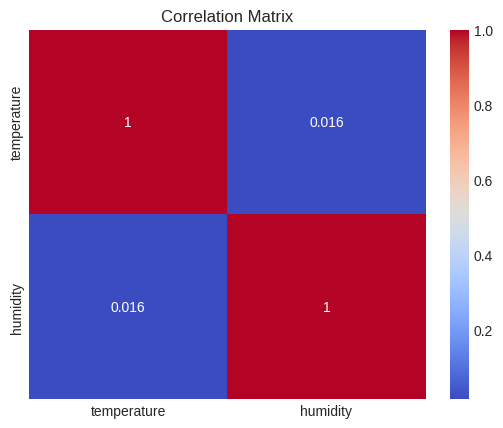

In [12]:
# Step 7: Correlation Heatmap
sns.heatmap(df[['temperature', 'humidity']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [21]:
from sklearn.ensemble import IsolationForest

# Fit the model
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly_iforest'] = iso_forest.fit_predict(scaled_features)

# -1 = anomaly, 1 = normal
df['anomaly_iforest'] = df['anomaly_iforest'].map({1: 0, -1: 1})  # 1 = anomaly
df[['timestamp', 'temperature', 'humidity', 'anomaly_iforest']].head()


,timestamp,temperature,humidity,anomaly_iforest
0,1970-01-01 00:00:00,24.80,43.70,0
1,1970-01-01 00:00:02,24.76,45.26,0
2,1970-01-01 00:00:04,24.83,44.97,0
3,1970-01-01 00:00:06,25.68,45.96,0
4,1970-01-01 00:00:08,25.84,46.24,0


In [22]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_label'] = dbscan.fit_predict(scaled_features)

# Mark noise (label -1) as anomaly
df['anomaly_dbscan'] = (df['dbscan_label'] == -1).astype(int)
df[['timestamp', 'temperature', 'humidity', 'anomaly_dbscan']].head()


,timestamp,temperature,humidity,anomaly_dbscan
0,1970-01-01 00:00:00,24.80,43.70,0
1,1970-01-01 00:00:02,24.76,45.26,0
2,1970-01-01 00:00:04,24.83,44.97,0
3,1970-01-01 00:00:06,25.68,45.96,0
4,1970-01-01 00:00:08,25.84,46.24,0


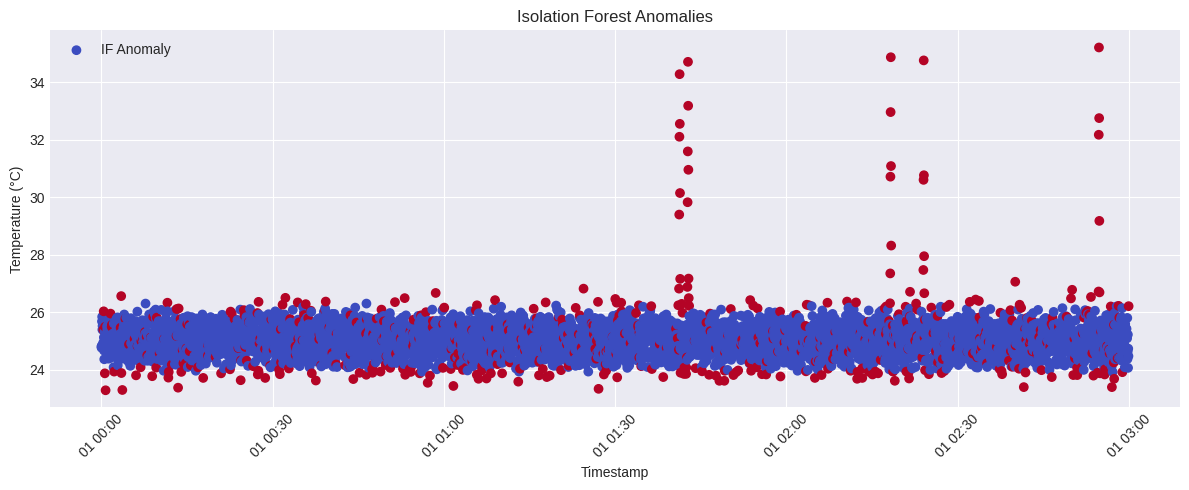

In [23]:
plt.figure(figsize=(12, 5))

# Plot Isolation Forest results
plt.scatter(df['timestamp'], df['temperature'], c=df['anomaly_iforest'], cmap='coolwarm', label='IF Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Isolation Forest Anomalies')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


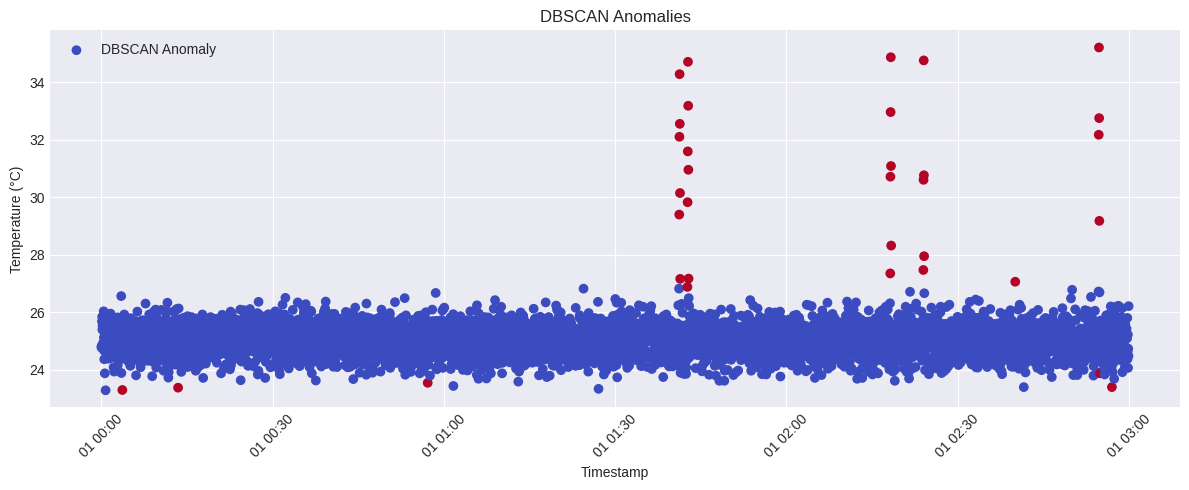

In [24]:
plt.figure(figsize=(12, 5))

# Plot DBSCAN results
plt.scatter(df['timestamp'], df['temperature'], c=df['anomaly_dbscan'], cmap='coolwarm', label='DBSCAN Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('DBSCAN Anomalies')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# Filter rows where either model detected an anomaly
anomalies = df[(df['anomaly_iforest'] == 1) | (df['anomaly_dbscan'] == 1)]

# Print each anomaly with context
for idx, row in anomalies.iterrows():
    source = []
    if row['anomaly_iforest'] == 1:
        source.append("Isolation Forest")
    if row['anomaly_dbscan'] == 1:
        source.append("DBSCAN")

    print(f"🚨 ALERT: Anomaly detected at {row['timestamp']} | Temp: {row['temperature']}°C, "
          f"Humidity: {row['humidity']}% | Source: {', '.join(source)}")


🚨 ALERT: Anomaly detected at 1970-01-01 00:00:20 | Temp: 25.39°C, Humidity: 48.61% | Source: Isolation Forest
🚨 ALERT: Anomaly detected at 1970-01-01 00:00:24 | Temp: 26.03°C, Humidity: 48.01% | Source: Isolation Forest
🚨 ALERT: Anomaly detected at 1970-01-01 00:00:36 | Temp: 23.87°C, Humidity: 44.29% | Source: Isolation Forest
🚨 ALERT: Anomaly detected at 1970-01-01 00:00:38 | Temp: 25.49°C, Humidity: 42.1% | Source: Isolation Forest
🚨 ALERT: Anomaly detected at 1970-01-01 00:00:44 | Temp: 23.28°C, Humidity: 45.43% | Source: Isolation Forest
🚨 ALERT: Anomaly detected at 1970-01-01 00:01:36 | Temp: 25.95°C, Humidity: 42.73% | Source: Isolation Forest
🚨 ALERT: Anomaly detected at 1970-01-01 00:01:48 | Temp: 25.49°C, Humidity: 49.41% | Source: Isolation Forest
🚨 ALERT: Anomaly detected at 1970-01-01 00:01:50 | Temp: 25.56°C, Humidity: 42.28% | Source: Isolation Forest
🚨 ALERT: Anomaly detected at 1970-01-01 00:02:14 | Temp: 23.93°C, Humidity: 46.6% | Source: Isolation Forest
🚨 ALERT: Ano

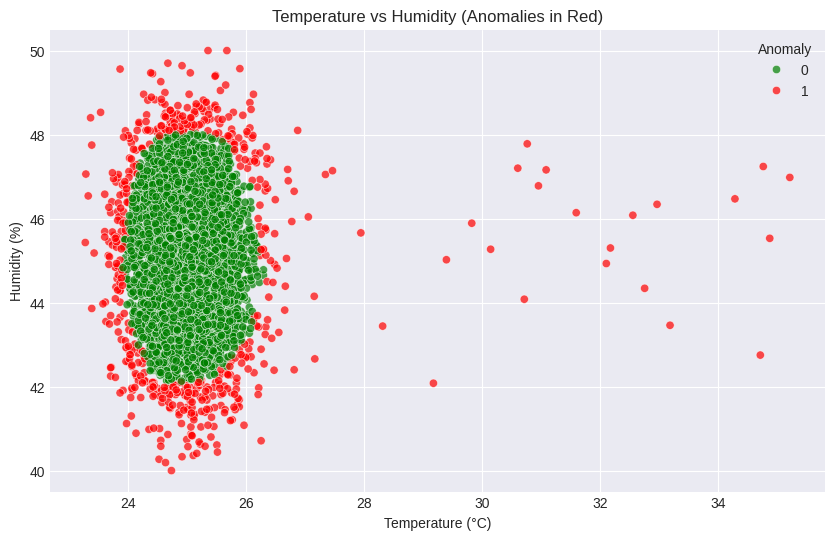

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step: Combine anomaly flags into one column
df['anomaly'] = ((df['anomaly_iforest'] == 1) | (df['anomaly_dbscan'] == 1)).astype(int)

# Step: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='temperature',
    y='humidity',
    hue='anomaly',
    palette={0: 'green', 1: 'red'},
    alpha=0.7
)
plt.title("Temperature vs Humidity (Anomalies in Red)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.legend(title="Anomaly")
plt.grid(True)
plt.show()
